In [2]:
!pip install pennylane
!pip install pyscf
!pip install openfermionpyscf

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.1/57.1 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 49.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 930.8/930.8 kB 40.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 71.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 66.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.9/167.9 kB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 86.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.2/51.2 MB 14.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.7/44.7 MB 19.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 62.8 MB/s eta 0:00:00
  Created wheel for pubchempy: filename=PubChemPy-1.0.4-py3-none-any.whl size=13818 sha256=463a5239198f9d05c9e04b35495a4cae297dd0a30beef6243f414dbd90070671
  Stored in direct

In [3]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.qchem import meanfield, hamiltonian, molecule
from openfermionpyscf import run_pyscf
from openfermion.transforms import jordan_wigner

In [2]:
# Step 1: Define molecule geometry and basis
symbols = ["O"]
coordinates = np.array([[-5.657757, 0.817590, 1.071928]])
name = "O6"

In [4]:
# Step 1: Define molecule geometry and basis
# symbols = ["O", "O", "O","O", "O", "O"]
# coordinates = np.array([[-5.657757, 0.817590, 1.071928], [-4.317877, -0.766435, -0.044156],[-8.408547, -2.015791, -0.133608], [-8.521959, 0.598954, -1.193235],[-5.798700, -2.852024, 0.876319], [-5.603549, 3.357719, -0.227529]])
# name = "O6"

In [3]:
# Step 2: Generate molecular Hamiltonian with PennyLane + PySCF
from pennylane import qchem
H, qubits = qchem.molecular_hamiltonian(name=name,
                        symbols=symbols,
                        coordinates=coordinates,
                        basis="sto-3g",
                        charge=0)

In [4]:
# Step 3: Setup a quantum device and VQE ansatz
dev = qml.device("default.qubit", wires=qubits)

@qml.qnode(dev)
def circuit(params):
    qml.templates.StronglyEntanglingLayers(params, wires=range(qubits))
    return qml.expval(H)

In [5]:
# Step 4: Optimize using gradient-free optimizer
np.random.seed(42)
params = np.random.normal(0, np.pi, (3, qubits, 3))  # 3 layers
opt = qml.GradientDescentOptimizer(stepsize=0.4)

max_iterations = 100
for i in range(max_iterations):
    params, energy = opt.step_and_cost(circuit, params)
    if i % 10 == 0:
        print(f"Iteration {i}: Energy = {energy:.8f} Ha")

# Final result
print(f"\nEstimated ground state energy of betalain: {energy:.8f} Hartree")

Iteration 0: Energy = -47.29760248 Ha
Iteration 10: Energy = -49.33972145 Ha
Iteration 20: Energy = -48.06563070 Ha
Iteration 30: Energy = -48.37688014 Ha
Iteration 40: Energy = -47.95014375 Ha
Iteration 50: Energy = -50.53270056 Ha
Iteration 60: Energy = -49.95692693 Ha
Iteration 70: Energy = -47.44790228 Ha
Iteration 80: Energy = -46.74084781 Ha
Iteration 90: Energy = -48.67689396 Ha

Estimated ground state energy of betalain: -55.77091172 Hartree


## VQE

In [11]:
# Step 1: Define molecule geometry and basis
symbols = ["O"]
coordinates = np.array([[-5.657757, 0.817590, 1.071928]])
name = "O6"

In [12]:
 H, qubits = qchem.molecular_hamiltonian (symbols, coordinates, charge=1, mult=2, method='openfermion')
 print(qubits) #the output is 10 qubits

10


In [15]:
#using hartceh -fock state
hf = qchem.hf_state(electrons=2, orbitals=10)
print(hf) # out [110000]

[1 1 0 0 0 0 0 0 0 0]


In [21]:
num_wires = qubits
dev= qml.device("default.qubit", wires=num_wires)

@qml.qnode(dev)
def exp_energy(state, hamiltonian):
  qml.BasisState(np.array(state), wires=range(num_wires))
  return qml.expval(hamiltonian)

In [22]:
exp_energy(hf, H)

tensor(-58.45093386, requires_grad=True)

In [32]:
#so this is how to cut on Double excitation state
def ansatz(params):
  qml.BasisState(hf, wires=range(num_wires))
  qml.DoubleExcitation(params[0], wires=[0,1,2,3])
  qml.DoubleExcitation(params[1], wires=[0,1,4,5])

In [30]:
@qml.qnode(dev)
def cost_function(params):
  ansatz(params)
  return qml.expval(H)

In [33]:
cost_function([0.1, 0.1])

array(-58.23081212)

##VQE 2

In [4]:
# Step 1: Define molecule geometry and basis
symbols = ["O"]
coordinates = np.array([[-5.657757, 0.817590, 1.071928]])
name = "O6"

In [5]:
# Step 2: Generate molecular Hamiltonian with PennyLane + PySCF
from pennylane import qchem
H, qubits = qchem.molecular_hamiltonian(name=name,
                        symbols=symbols,
                        coordinates=coordinates,
                        basis="sto-3g",
                        charge=0)

In [6]:
print("The Hamiltonian is ", H)

The Hamiltonian is  -47.023152085461504 * I([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]) + 12.420195209968337 * Z(0) + 12.420195209968337 * Z(1) + 1.187682643750154 * (Z(0) @ Z(1)) + -0.13926538543993164 * (Y(0) @ Z(1) @ Y(2)) + -0.13926538543993164 * (X(0) @ Z(1) @ X(2)) + 1.6560274370358932 * Z(2) + 0.2600909373705601 * (Z(0) @ Z(2)) + -0.1180027522385491 * (Y(0) @ Y(2)) + -0.1180027522385491 * (X(0) @ X(2)) + 0.27851512082907315 * (Z(1) @ Z(2)) + -0.13926538543993167 * (Y(1) @ Z(2) @ Y(3)) + -0.1180027522385491 * (Z(0) @ Y(1) @ Z(2) @ Y(3)) + -0.13926538543993167 * (X(1) @ Z(2) @ X(3)) + -0.1180027522385491 * (Z(0) @ X(1) @ Z(2) @ X(3)) + 0.018424183458513075 * (Y(0) @ X(1) @ X(2) @ Y(3)) + -0.018424183458513075 * (Y(0) @ Y(1) @ X(2) @ X(3)) + -0.018424183458513075 * (X(0) @ X(1) @ Y(2) @ Y(3)) + 0.018424183458513075 * (X(0) @ Y(1) @ Y(2) @ X(3)) + 1.656027437035893 * Z(3) + 0.27851512082907315 * (Z(0) @ Z(3)) + -0.00540898015809356 * (Y(0) @ Z(1) @ Y(2) @ Z(3)) + -0.00540898015809356 * (X(0) @ 

In [7]:
dev = qml.device("lightning.qubit", wires=qubits)

In [21]:
electrons = 2
hf = qml.qchem.hf_state(electrons, qubits)
print(hf)

[1 1 0 0 0 0 0 0 0 0]


In [22]:
@qml.qnode(dev, interface="jax")
def circuit(param, wires):
    qml.BasisState(hf, wires=wires)
    qml.DoubleExcitation(param, wires=[0, 1, 2, 3])
    return qml.expval(H)

In [23]:
def cost_fn(param):
    return circuit(param, wires=range(qubits))

In [24]:
import optax

max_iterations = 100
conv_tol = 1e-06

opt = optax.sgd(learning_rate=0.4)

In [28]:
import jax

theta = np.array(0.)

# store the values of the cost function
energy = [cost_fn(theta)]

# store the values of the circuit parameter
angle = [theta]

opt_state = opt.init(theta)

for n in range(max_iterations):

    gradient = jax.grad(cost_fn)(theta)
    updates, opt_state = opt.update(gradient, opt_state)
    theta = optax.apply_updates(theta, updates)

    angle.append(theta)
    energy.append(cost_fn(theta))

    conv = np.abs(energy[-1] - energy[-2])

    if n % 2 == 0:
        print(f"Step = {n},  Energy = {energy[-1]:.8f} Ha")

    if conv <= conv_tol:
        break

print("\n" f"Final value of the ground-state energy = {energy[-1]:.8f} Ha")
print("\n" f"Optimal value of the circuit parameter = {angle[-1]:.4f}")

Step = 0,  Energy = -58.44239807 Ha
Step = 2,  Energy = -32.95085526 Ha
Step = 4,  Energy = -56.21562958 Ha
Step = 6,  Energy = -57.98031235 Ha
Step = 8,  Energy = -45.25260162 Ha
Step = 10,  Energy = -55.97813034 Ha
Step = 12,  Energy = -31.39382553 Ha
Step = 14,  Energy = -57.51206970 Ha
Step = 16,  Energy = -31.19547462 Ha
Step = 18,  Energy = -56.53544617 Ha
Step = 20,  Energy = -22.34598732 Ha
Step = 22,  Energy = -49.76992035 Ha
Step = 24,  Energy = -56.59838867 Ha
Step = 26,  Energy = -15.10875988 Ha
Step = 28,  Energy = -55.90626144 Ha
Step = 30,  Energy = -22.46667862 Ha
Step = 32,  Energy = -51.68925095 Ha
Step = 34,  Energy = -33.44023132 Ha
Step = 36,  Energy = -54.44500732 Ha
Step = 38,  Energy = -49.40439224 Ha
Step = 40,  Energy = -57.18283081 Ha
Step = 42,  Energy = -35.29164124 Ha
Step = 44,  Energy = -48.65662003 Ha
Step = 46,  Energy = -32.08551407 Ha
Step = 48,  Energy = -58.36057281 Ha
Step = 50,  Energy = -47.28186035 Ha
Step = 52,  Energy = -18.13390923 Ha
Step =

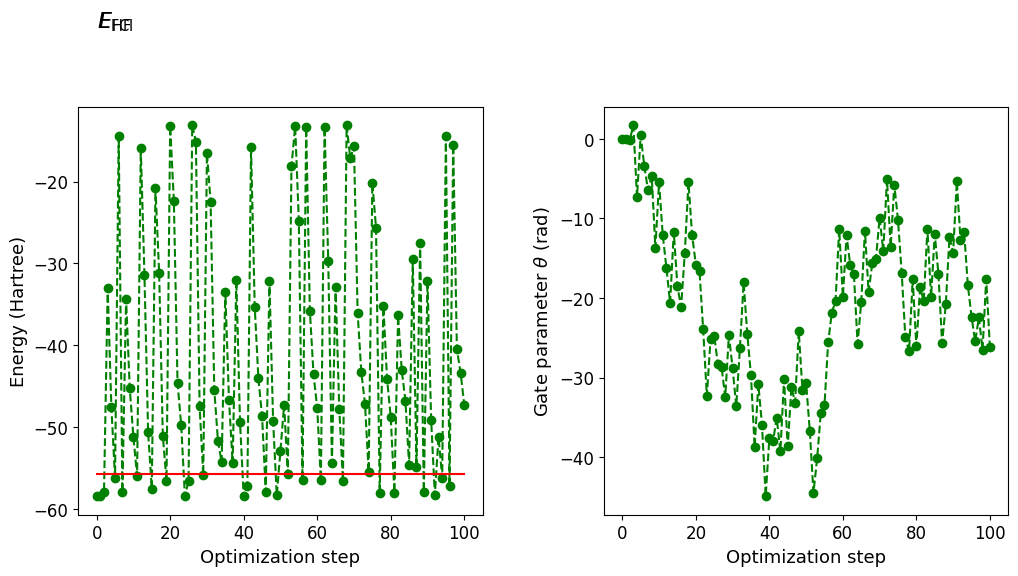

In [25]:
import matplotlib.pyplot as plt

fig = plt.figure()
fig.set_figheight(6)
fig.set_figwidth(12)

# Full configuration interaction (FCI) energy computed classically
E_fci = -47.25605011

# Add energy plot on column 1
ax1 = fig.add_subplot(121)
ax1.plot(range(n + 2), energy, "go", ls="dashed")
ax1.plot(range(n + 2), np.full(n + 2, E_fci), color="red")
ax1.set_xlabel("Optimization step", fontsize=13)
ax1.set_ylabel("Energy (Hartree)", fontsize=13)
ax1.text(0.5, -1.1176, r"$E_\mathrm{HF}$", fontsize=15)
ax1.text(0, -1.1357, r"$E_\mathrm{FCI}$", fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Add angle plot on column 2
ax2 = fig.add_subplot(122)
ax2.plot(range(n + 2), angle, "go", ls="dashed")
ax2.set_xlabel("Optimization step", fontsize=13)
ax2.set_ylabel("Gate parameter $\\theta$ (rad)", fontsize=13)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.subplots_adjust(wspace=0.3, bottom=0.2)
plt.show()